In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pickle, math, datetime
from pprint import pformat
from graphviz import Digraph
from itertools import combinations, permutations
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix
from scipy.stats import entropy

import hmms
import os
import math

In [193]:
# Configuration parameters
K = 3
# Higher results in more rejections
rejection_KL_thresh = 0.01
N_nodes = 81
random_state = 2
# rejection_negative_bias = 2
# pbl_negative_bias = 0
# pbr_negative_bias = 2
# rotl_negative_bias = 4
# rotr_negative_bias = 3
# pc_negative_bias = 0
rejection_negative_bias = 0
pbl_negative_bias = 0
pbr_negative_bias = 0
rotl_negative_bias = 0
rotr_negative_bias = 0
pcl_negative_bias = 0
pcr_negative_bias = 0

rejections_trained = False
# baum_welch = True
# bw_epochs = 10

# Observation matrix params
prob_emission_equals_hidden = 0.95

prob_emission_not_equals_hidden = 1 - prob_emission_equals_hidden

#Trans prob matrix params
trans_prob_factor = 100
rejection_trans_prob_factor = 1

#Init prob matrix params
init_prob_factor = 100
rejection_init_prob_factor = 1

classes = ["PBL", "PBR", "ROTL", "ROTR", "PCL", "PCR"]

## Load QTC_C sequences (participants interacting in lab study)

In [194]:
rotl_study_seqs = []
rotr_study_seqs = []
pb_l_study_seqs = []
pb_r_study_seqs = []
pcl_study_seqs = []
pcr_study_seqs = []
u_study_seqs = []
u_study_seqs_no_train = []

with open("hf_study_qtc_seqs.pickle", "rb") as f:
    study_seqs = pickle.load(f)
study_seqs

len(study_seqs)

for key in study_seqs.keys():
    class_code = key.split("_")[0]
    print(class_code)
    
    if "rotl" in key:
        rotl_study_seqs = study_seqs[key]
    elif "rotr" in key:
        rotr_study_seqs = study_seqs[key]
    elif "pb" in class_code:
        if class_code[-1] == "l":
            pb_l_study_seqs = study_seqs[key]
        elif class_code[-1] == "r":
            pb_r_study_seqs = study_seqs[key]
    elif "pcl" in key:
        pcl_study_seqs = study_seqs[key]
    elif "pcr" in key:
        pcr_study_seqs = study_seqs[key]
    elif "u" in key:
        u_study_seqs = study_seqs[key]

pbr
pcr
rotr
u
rotl
pcl
pbl


In [195]:
print(len(rotl_study_seqs))
print(len(rotr_study_seqs))
print(len(pb_l_study_seqs))
print(len(pb_r_study_seqs))
print(len(pcl_study_seqs))
print(len(pcr_study_seqs))
print(len(u_study_seqs))

45
23
29
26
36
20
23


## Load QTC_C sequences (expert interacting in lab)

In [196]:
# with open("hf_expert_qtc_seqs.pickle", "rb") as f:
#     study_seqs = pickle.load(f)
# study_seqs

# len(study_seqs)

# for key in study_seqs.keys():
#     class_code = key.split("_")[0]
#     print(class_code)
    
#     if "rotl" in key:
#         rotl_study_seqs += study_seqs[key]
#     elif "rotr" in key:
#         rotr_study_seqs += study_seqs[key]
#     elif "pb" in class_code:
#         if class_code[-1] == "l":
#             pb_l_study_seqs += study_seqs[key]
#         elif class_code[-1] == "r":
#             pb_r_study_seqs += study_seqs[key]
#     elif "pcl" in key:
#         pcl_study_seqs += study_seqs[key]
#     elif "pcr" in key:
#         pcr_study_seqs += study_seqs[key]
#     elif "u" in key:
#         u_study_seqs += study_seqs[key]

In [197]:
print(len(rotl_study_seqs))
print(len(rotr_study_seqs))
print(len(pb_l_study_seqs))
print(len(pb_r_study_seqs))
print(len(pcl_study_seqs))
print(len(pcr_study_seqs))
print(len(u_study_seqs))

45
23
29
26
36
20
23


In [198]:
rotl_study_seqs = [[state.replace(",", "") for state in seq] for seq in rotl_study_seqs]
rotr_study_seqs = [[state.replace(",", "") for state in seq] for seq in rotr_study_seqs]
pb_l_study_seqs = [[state.replace(",", "") for state in seq] for seq in pb_l_study_seqs]
pb_r_study_seqs = [[state.replace(",", "") for state in seq] for seq in pb_r_study_seqs]
pcl_study_seqs = [[state.replace(",", "") for state in seq] for seq in pcl_study_seqs]
pcr_study_seqs = [[state.replace(",", "") for state in seq] for seq in pcr_study_seqs]
u_study_seqs = [[state.replace(",", "") for state in seq] for seq in u_study_seqs]

In [199]:
# Create list of QTC_C states so that indices can be used as integer state IDs compatible with HMM library
QTC_symbols = []
for i in range(0,4):
    QTC_symbols.append("-")
    QTC_symbols.append("0")
    QTC_symbols.append("+")
print("QTC symbols:", QTC_symbols[:3])
QTC_C_states = list(combinations(QTC_symbols, 4))
QTC_C_states = [state[0] + state[1] + state[2] + state[3] for state in QTC_C_states]
QTC_C_states = list(np.unique(QTC_C_states))
print("QTC_C states:\n", QTC_C_states)
print(len(QTC_C_states), "states total")

QTC symbols: ['-', '0', '+']
QTC_C states:
 ['++++', '+++-', '+++0', '++-+', '++--', '++-0', '++0+', '++0-', '++00', '+-++', '+-+-', '+-+0', '+--+', '+---', '+--0', '+-0+', '+-0-', '+-00', '+0++', '+0+-', '+0+0', '+0-+', '+0--', '+0-0', '+00+', '+00-', '+000', '-+++', '-++-', '-++0', '-+-+', '-+--', '-+-0', '-+0+', '-+0-', '-+00', '--++', '--+-', '--+0', '---+', '----', '---0', '--0+', '--0-', '--00', '-0++', '-0+-', '-0+0', '-0-+', '-0--', '-0-0', '-00+', '-00-', '-000', '0+++', '0++-', '0++0', '0+-+', '0+--', '0+-0', '0+0+', '0+0-', '0+00', '0-++', '0-+-', '0-+0', '0--+', '0---', '0--0', '0-0+', '0-0-', '0-00', '00++', '00+-', '00+0', '00-+', '00--', '00-0', '000+', '000-', '0000']
81 states total


In [9]:
def QTC_C_to_num(QTC_C):
    return QTC_C_states.index(QTC_C)


def QTC_C_seq_to_num_seq(QTC_C_seq):
    num_seq = []
    for QTC_C in QTC_C_seq:
        num_seq.append(QTC_C_to_num(QTC_C))

    return num_seq


def num_to_QTC_C(num):
    return QTC_C_states[num]


def num_seq_to_QTC_C_seq(num_seq):
    QTC_C_seq = []
    for num in num_seq:
        QTC_C_seq.append(num_to_QTC_C(num))

    return QTC_C_seq


print(QTC_C_to_num("++--"))
print(num_to_QTC_C(8))
print(num_seq_to_QTC_C_seq([0, 1, 2, 3]))
print(QTC_C_seq_to_num_seq(num_seq_to_QTC_C_seq([0, 1, 2, 3])))

4
++00
['++++', '+++-', '+++0', '++-+']
[0, 1, 2, 3]


In [10]:
# Defining a uniform transition matrix of N_nodes states
uniform_trans_mat = np.zeros((N_nodes, N_nodes))
uniform_trans_mat = np.array([[1/N_nodes for trans in row] for row in uniform_trans_mat])
print("\n", uniform_trans_mat)
row_sums = []
for row in uniform_trans_mat:
    row_sums.append(np.sum(row))
print(np.mean(row_sums))


 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0


In [11]:
def draw_transition_matrix(trans_matrix, filename, min_trans_prob):
    # draw its transition matrix
    dot = Digraph(comment='HMM model')
    col, row = trans_matrix.shape
    for i in range(0, col):
        for j in range(0, row):
#             print(i, j, trans_matrix[i, j])
            if trans_matrix[i, j] >= min_trans_prob:
#                 print(i, j, "is a high probability transition")
                dot.edge(num_to_QTC_C(i), num_to_QTC_C(j), label='{:2.2f}'.format(trans_matrix[i, j]))

    dot.render(filename, view=True)

## Creating pass-by left HMM

In [12]:
pass_by_l_seqs = pb_l_study_seqs

In [13]:
pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]
print(pass_by_l_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_l_seqs]

[[37], [37, 40], [37, 40, 4], [16], [16, 13], [16, 13, 40], [16, 13, 40, 4], [40], [40, 10], [40, 10, 4], [37], [37, 27], [37, 27, 4], [40], [40, 4], [40, 4, 31], [40, 4, 31, 27], [40], [40, 4], [40, 4, 31], [40], [40, 4], [40], [40, 4], [37], [37, 27], [37, 27, 40], [37, 27, 40, 4], [40], [40], [40], [40], [40, 4], [40], [40, 49], [40, 49, 4], [40], [40, 58], [40, 58, 4], [40], [40, 37], [40, 37, 40], [40, 37, 40, 4], [40], [40, 1], [40], [40, 49], [40, 49, 58], [40, 49, 58, 4], [40], [40, 4], [37], [37, 40]]


[['--+-'],
 ['--+-', '----'],
 ['--+-', '----', '++--'],
 ['+-0-'],
 ['+-0-', '+---'],
 ['+-0-', '+---', '----'],
 ['+-0-', '+---', '----', '++--'],
 ['----'],
 ['----', '+-+-'],
 ['----', '+-+-', '++--'],
 ['--+-'],
 ['--+-', '-+++'],
 ['--+-', '-+++', '++--'],
 ['----'],
 ['----', '++--'],
 ['----', '++--', '-+--'],
 ['----', '++--', '-+--', '-+++'],
 ['----'],
 ['----', '++--'],
 ['----', '++--', '-+--'],
 ['----'],
 ['----', '++--'],
 ['----'],
 ['----', '++--'],
 ['--+-'],
 ['--+-', '-+++'],
 ['--+-', '-+++', '----'],
 ['--+-', '-+++', '----', '++--'],
 ['----'],
 ['----'],
 ['----'],
 ['----'],
 ['----', '++--'],
 ['----'],
 ['----', '-0--'],
 ['----', '-0--', '++--'],
 ['----'],
 ['----', '0+--'],
 ['----', '0+--', '++--'],
 ['----'],
 ['----', '--+-'],
 ['----', '--+-', '----'],
 ['----', '--+-', '----', '++--'],
 ['----'],
 ['----', '+++-'],
 ['----'],
 ['----', '-0--'],
 ['----', '-0--', '0+--'],
 ['----', '-0--', '0+--', '++--'],
 ['----'],
 ['----', '++--'],
 ['--+-'],
 ['-

In [14]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_l_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
0
1
0
0
1
0
1
2
0
0
1
0
0
1
0
0
1
0
1
2
0
0
1
0
0
0
0
1
0
1
2
0
0
0
1
0
0
1
0
0
1
0
1
2
0
0
0
1
0
1
2
0
0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [15]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_l_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pblHMM = hmms.DtHMM(A, B, Pi)

# Check pblHMM params
A, B, Pi = pblHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0
B:
 [[9.50617284e-01 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 9.50617284e-01 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 9.50617284e-01 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 ...
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 9.50617284e-01
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  9.50617284e-01 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-

In [16]:
# draw_transition_matrix(A,"QTC_C_Pass-By-Left_Lab_Egs_Transitions", 0.013)

Pass-by left HMM:


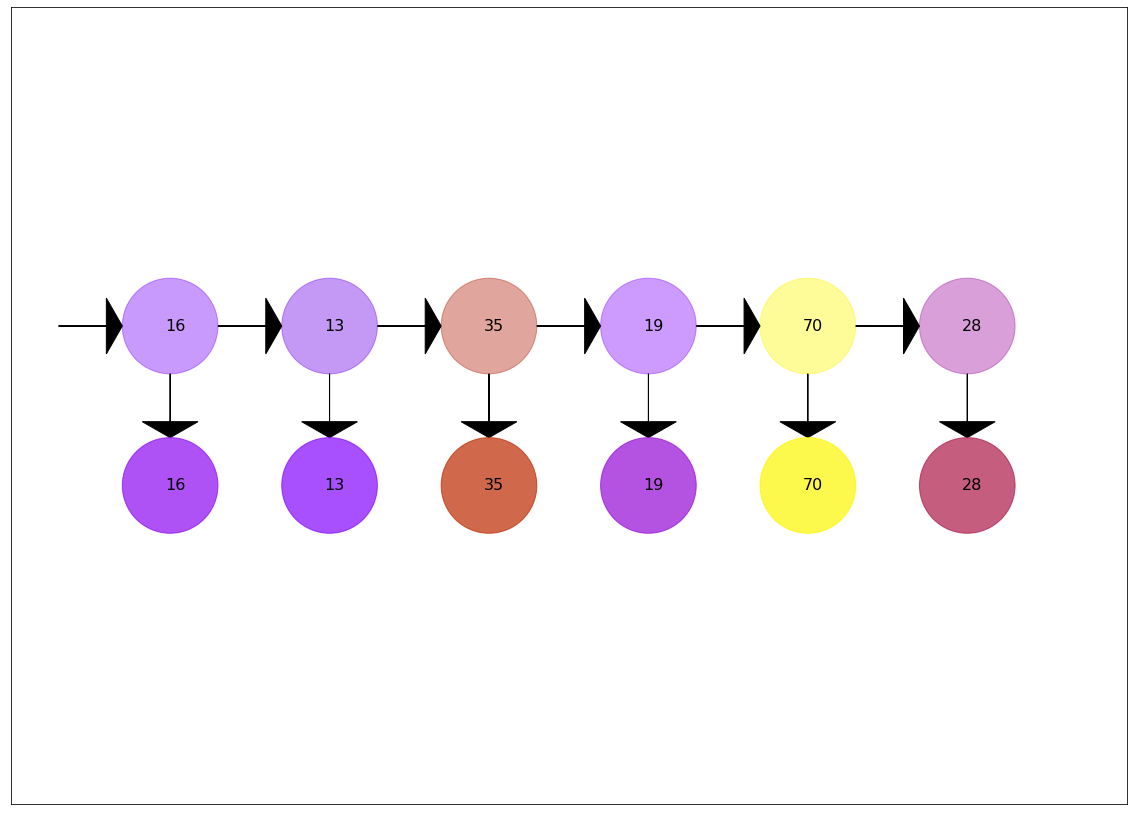

['+-0-', '+---', '-+00', '+0+-', '0-0-', '-++-']


In [17]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pblHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating pass-by right HMM

In [18]:
pass_by_r_seqs = pb_r_study_seqs

In [19]:
pass_by_r_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_r_seqs]
print(pass_by_r_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_r_seqs]

[[36], [36, 0], [36], [36, 27], [36], [36, 0], [36], [36, 45], [38], [38, 36], [38, 36, 27], [36], [36, 27], [36, 27, 36], [36, 27, 36, 0], [36], [36], [36, 27], [36, 27, 31], [36], [36, 30], [36, 30, 36], [36, 30, 36, 0], [38], [38, 36], [38, 36, 27], [36], [36, 0], [36], [36, 47], [36, 47, 20], [36], [36, 27], [36], [36], [38], [38, 36], [38, 36, 45], [38, 36, 45, 27], [36], [36, 45], [36, 45, 36], [36], [38], [38, 36], [38, 36, 45], [36]]


[['--++'],
 ['--++', '++++'],
 ['--++'],
 ['--++', '-+++'],
 ['--++'],
 ['--++', '++++'],
 ['--++'],
 ['--++', '-0++'],
 ['--+0'],
 ['--+0', '--++'],
 ['--+0', '--++', '-+++'],
 ['--++'],
 ['--++', '-+++'],
 ['--++', '-+++', '--++'],
 ['--++', '-+++', '--++', '++++'],
 ['--++'],
 ['--++'],
 ['--++', '-+++'],
 ['--++', '-+++', '-+--'],
 ['--++'],
 ['--++', '-+-+'],
 ['--++', '-+-+', '--++'],
 ['--++', '-+-+', '--++', '++++'],
 ['--+0'],
 ['--+0', '--++'],
 ['--+0', '--++', '-+++'],
 ['--++'],
 ['--++', '++++'],
 ['--++'],
 ['--++', '-0+0'],
 ['--++', '-0+0', '+0+0'],
 ['--++'],
 ['--++', '-+++'],
 ['--++'],
 ['--++'],
 ['--+0'],
 ['--+0', '--++'],
 ['--+0', '--++', '-0++'],
 ['--+0', '--++', '-0++', '-+++'],
 ['--++'],
 ['--++', '-0++'],
 ['--++', '-0++', '--++'],
 ['--++'],
 ['--+0'],
 ['--+0', '--++'],
 ['--+0', '--++', '-0++'],
 ['--++']]

In [20]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_r_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
0
0
0
0
0
1
0
0
1
0
1
2
0
0
1
0
0
1
0
1
2
0
0
1
0
0
0
1
0
0
0
1
0
1
2
0
0
1
0
0
1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [21]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_r_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pbrHMM = hmms.DtHMM(A, B, Pi)

# Check pbrHMM params
A, B, Pi = pbrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
0.9999999999999998
B:
 [[9.50617284e-01 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 9.50617284e-01 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 9.50617284e-01 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 ...
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 9.50617284e-01
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  9.50617284e-01 6.17283951e-04]
 [6.17283951e-04 6.17283951e-

In [22]:
# draw_transition_matrix(A,"QTC_C_Pass-By-Right_Lab_Egs_Transitions", 0.013)

Pass-by right HMM:


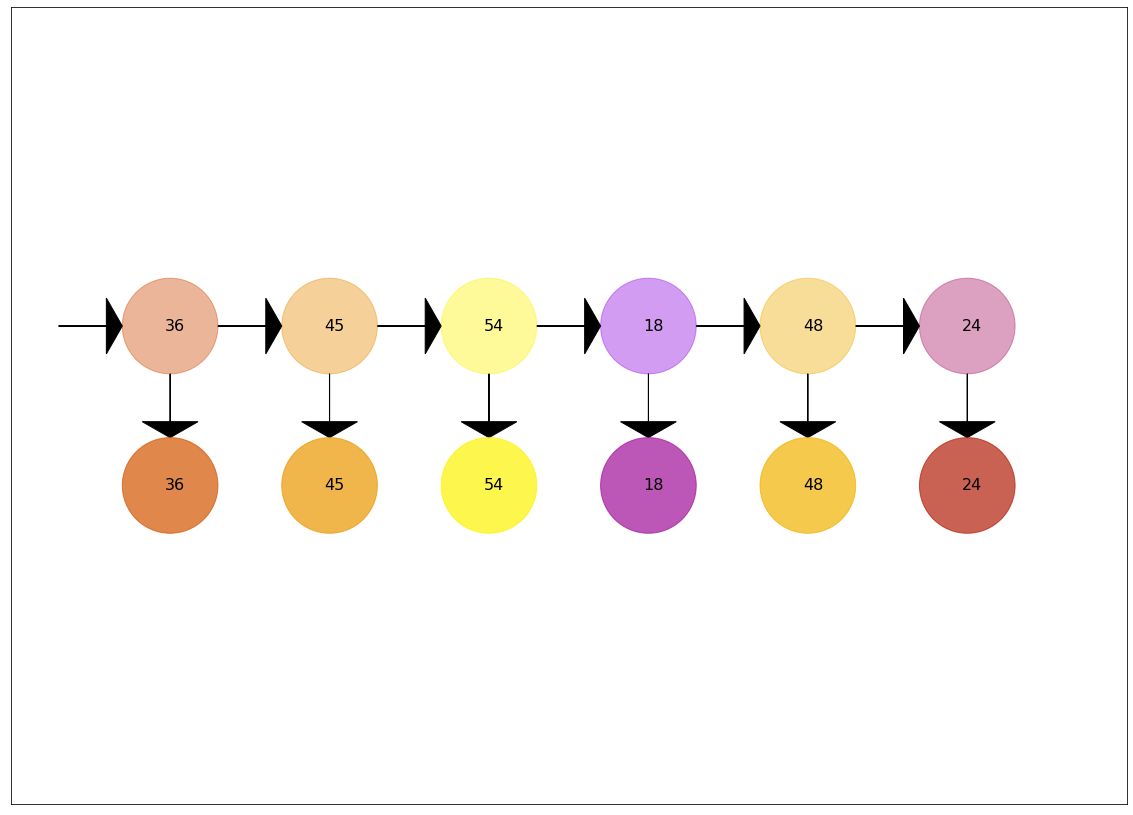

['--++', '-0++', '0+++', '+0++', '-0-+', '+00+']


In [23]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pbrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating robot overtakes left HMM

In [24]:
rotl_seqs = rotl_study_seqs

In [25]:
rotl_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotl_seqs]
print(rotl_seqs)
[list(map(num_to_QTC_C, seq)) for seq in rotl_seqs]

[[10], [10, 13], [10, 13, 40], [10, 13, 40, 28], [10, 13, 40, 28, 29], [10, 13, 40, 28, 29, 10], [10], [10, 37], [10, 37, 10], [10, 37, 10, 64], [10, 37, 10, 64, 10], [10], [10, 64], [10, 64, 10], [10, 64, 10, 37], [13], [13, 10], [10], [10, 16], [10, 16, 10], [10, 16, 10, 55], [10, 16, 10, 55, 40], [10, 16, 10, 55, 40, 46], [10, 16, 10, 55, 40, 46, 7], [10, 16, 10, 55, 40, 46, 7, 73], [10, 16, 10, 55, 40, 46, 7, 73, 47], [10, 16, 10, 55, 40, 46, 7, 73, 47, 20], [10, 16, 10, 55, 40, 46, 7, 73, 47, 20, 47], [13], [13, 10], [16], [16, 10], [16, 10, 64], [16, 10, 64, 10], [16, 10, 64, 10, 19], [16, 10, 64, 10, 19, 73], [16, 10, 64, 10, 19, 73, 47], [10], [10], [10, 27], [10, 27, 10], [10, 27, 10, 40], [10], [10, 13], [10, 13, 10], [10], [10, 40], [10, 40, 10], [10], [10, 40], [10, 40, 43], [10, 40, 43, 37], [10, 40, 43, 37, 40], [10, 40, 43, 37, 40, 27], [10, 40, 43, 37, 40, 27, 10], [13], [13, 10], [10], [10, 40], [10, 40, 10], [64], [64, 40], [64, 40, 37], [64, 40, 37, 3], [64, 40, 37, 

[['+-+-'],
 ['+-+-', '+---'],
 ['+-+-', '+---', '----'],
 ['+-+-', '+---', '----', '-++-'],
 ['+-+-', '+---', '----', '-++-', '-++0'],
 ['+-+-', '+---', '----', '-++-', '-++0', '+-+-'],
 ['+-+-'],
 ['+-+-', '--+-'],
 ['+-+-', '--+-', '+-+-'],
 ['+-+-', '--+-', '+-+-', '0-+-'],
 ['+-+-', '--+-', '+-+-', '0-+-', '+-+-'],
 ['+-+-'],
 ['+-+-', '0-+-'],
 ['+-+-', '0-+-', '+-+-'],
 ['+-+-', '0-+-', '+-+-', '--+-'],
 ['+---'],
 ['+---', '+-+-'],
 ['+-+-'],
 ['+-+-', '+-0-'],
 ['+-+-', '+-0-', '+-+-'],
 ['+-+-', '+-0-', '+-+-', '0++-'],
 ['+-+-', '+-0-', '+-+-', '0++-', '----'],
 ['+-+-', '+-0-', '+-+-', '0++-', '----', '-0+-'],
 ['+-+-', '+-0-', '+-+-', '0++-', '----', '-0+-', '++0-'],
 ['+-+-', '+-0-', '+-+-', '0++-', '----', '-0+-', '++0-', '00+-'],
 ['+-+-', '+-0-', '+-+-', '0++-', '----', '-0+-', '++0-', '00+-', '-0+0'],
 ['+-+-',
  '+-0-',
  '+-+-',
  '0++-',
  '----',
  '-0+-',
  '++0-',
  '00+-',
  '-0+0',
  '+0+0'],
 ['+-+-',
  '+-0-',
  '+-+-',
  '0++-',
  '----',
  '-0+-',
  '++0-',

In [26]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in rotl_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
0
1
0
1
2
0
1
2
3
0
0
1
0
1
2
0
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
0
1
0
1
2
0
0
1
0
0
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
0
0
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
0
1
0
1
2
0
0
0
1
0
1
2
0
0
1
0
0
1
0
1
2
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.012

In [27]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in rotl_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
rotlHMM = hmms.DtHMM(A, B, Pi)

# Check rotlHMM params
A, B, Pi = rotlHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 6.92160840e-01 1.19317504e-04
 1.19317504e-04 7.17098198e-02 1.19317504e-04 1.19317504e-04
 8.36415702e-02 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 2.39828183e-02 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 1.19317504e-04 4.78463191e-02
 1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 1.19317504e-04 1.19317504e-04 1.19317504e-04 1.19317504e-04
 7.17098198e-02 1.19

In [28]:
A.min()

0.00014532771399505885

In [29]:
# draw_transition_matrix(A, "QTC_C_Robot-Overtakes-Left_Lab_Egs_Transitions", 0.0124)

Robot overtakes left HMM:


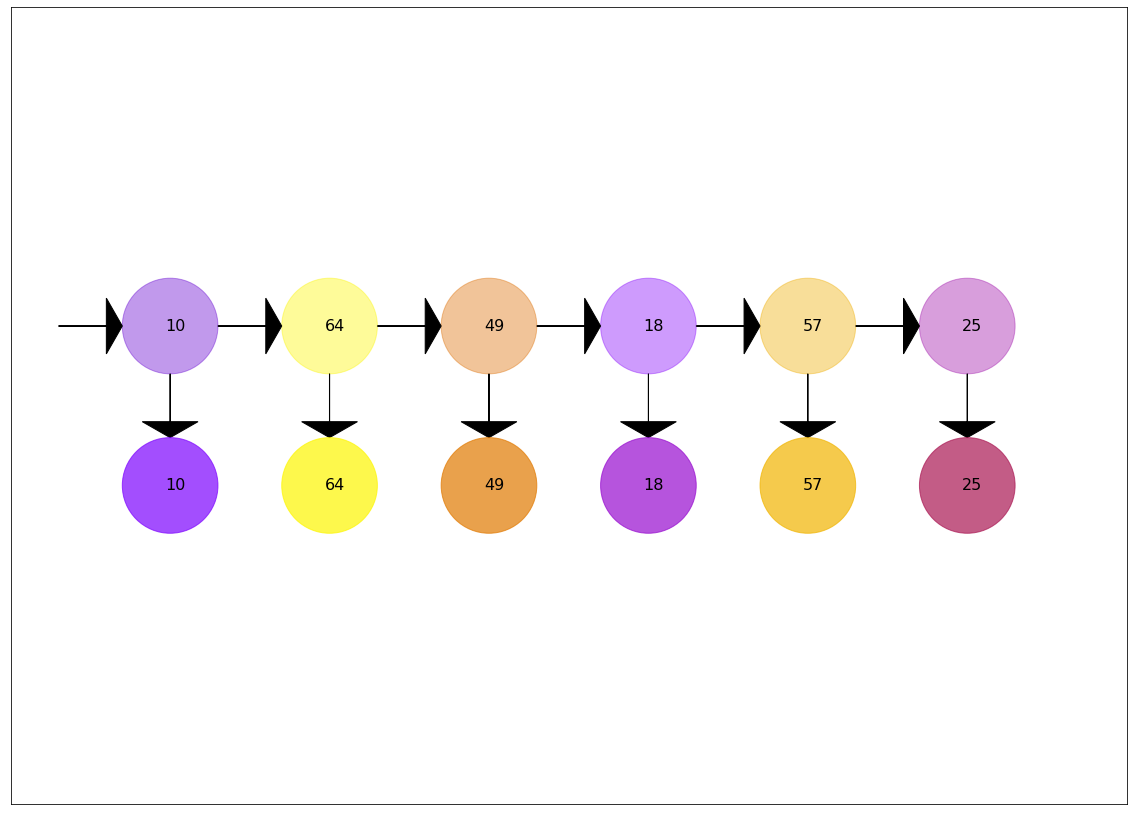

['+-+-', '0-+-', '-0--', '+0++', '0+-+', '+00-']


In [30]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = rotlHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Robot overtakes left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating robot overtakes right HMM

In [31]:
rotr_seqs = rotr_study_seqs

In [32]:
rotr_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotr_seqs]
print(rotr_seqs)
[list(map(num_to_QTC_C, seq)) for seq in rotr_seqs]

[[12], [12, 15], [12, 15, 36], [12, 15, 36, 27], [12, 15, 36, 27, 30], [12, 15, 36, 27, 30, 12], [12, 15, 36, 27, 30, 12, 39], [12], [12], [12], [12], [12, 63], [12, 63, 12], [12, 63, 12, 39], [12], [12], [12], [12, 39], [12, 39, 21], [12], [12, 27], [12, 27, 12], [12], [12], [15], [15, 39], [15, 39, 12], [12], [12, 36], [12, 36, 12], [12], [69], [69, 12], [69, 12, 15], [69, 12, 15, 63], [69, 12, 15, 63, 12], [12], [12], [9], [9, 12], [9, 12, 66], [9, 12, 66, 12], [12], [12, 15], [12], [12, 9], [12, 9, 12]]


[['+--+'],
 ['+--+', '+-0+'],
 ['+--+', '+-0+', '--++'],
 ['+--+', '+-0+', '--++', '-+++'],
 ['+--+', '+-0+', '--++', '-+++', '-+-+'],
 ['+--+', '+-0+', '--++', '-+++', '-+-+', '+--+'],
 ['+--+', '+-0+', '--++', '-+++', '-+-+', '+--+', '---+'],
 ['+--+'],
 ['+--+'],
 ['+--+'],
 ['+--+'],
 ['+--+', '0-++'],
 ['+--+', '0-++', '+--+'],
 ['+--+', '0-++', '+--+', '---+'],
 ['+--+'],
 ['+--+'],
 ['+--+'],
 ['+--+', '---+'],
 ['+--+', '---+', '+0-+'],
 ['+--+'],
 ['+--+', '-+++'],
 ['+--+', '-+++', '+--+'],
 ['+--+'],
 ['+--+'],
 ['+-0+'],
 ['+-0+', '---+'],
 ['+-0+', '---+', '+--+'],
 ['+--+'],
 ['+--+', '--++'],
 ['+--+', '--++', '+--+'],
 ['+--+'],
 ['0-0+'],
 ['0-0+', '+--+'],
 ['0-0+', '+--+', '+-0+'],
 ['0-0+', '+--+', '+-0+', '0-++'],
 ['0-0+', '+--+', '+-0+', '0-++', '+--+'],
 ['+--+'],
 ['+--+'],
 ['+-++'],
 ['+-++', '+--+'],
 ['+-++', '+--+', '0--+'],
 ['+-++', '+--+', '0--+', '+--+'],
 ['+--+'],
 ['+--+', '+-0+'],
 ['+--+'],
 ['+--+', '+-++'],
 ['+--+', '+-++', '+--+']]

In [33]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in rotr_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
0
1
0
1
2
0
0
1
0
0
1
0
0
1
0
0
1
0
0
1
0
1
2
0
1
2
3
0
0
1
0
1
2
0
0
0
1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [34]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in rotr_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
rotrHMM = hmms.DtHMM(A, B, Pi)

# Check rotrHMM params
A, B, Pi = rotrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 8.38736666e-02 2.09161263e-04 2.09161263e-04
 7.32273583e-01 2.09161263e-04 2.09161263e-04 6.29575403e-02
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09161263e-04 2.09161263e-04 2.09161263e-04
 2.09161263e-04 2.09

In [35]:
A.min()

0.0003874467260751645

In [36]:
# draw_transition_matrix(A, "QTC_C_Robot-Overtakes-Right_Lab_Egs_Transitions", 0.0124)

Robot overtakes right HMM:


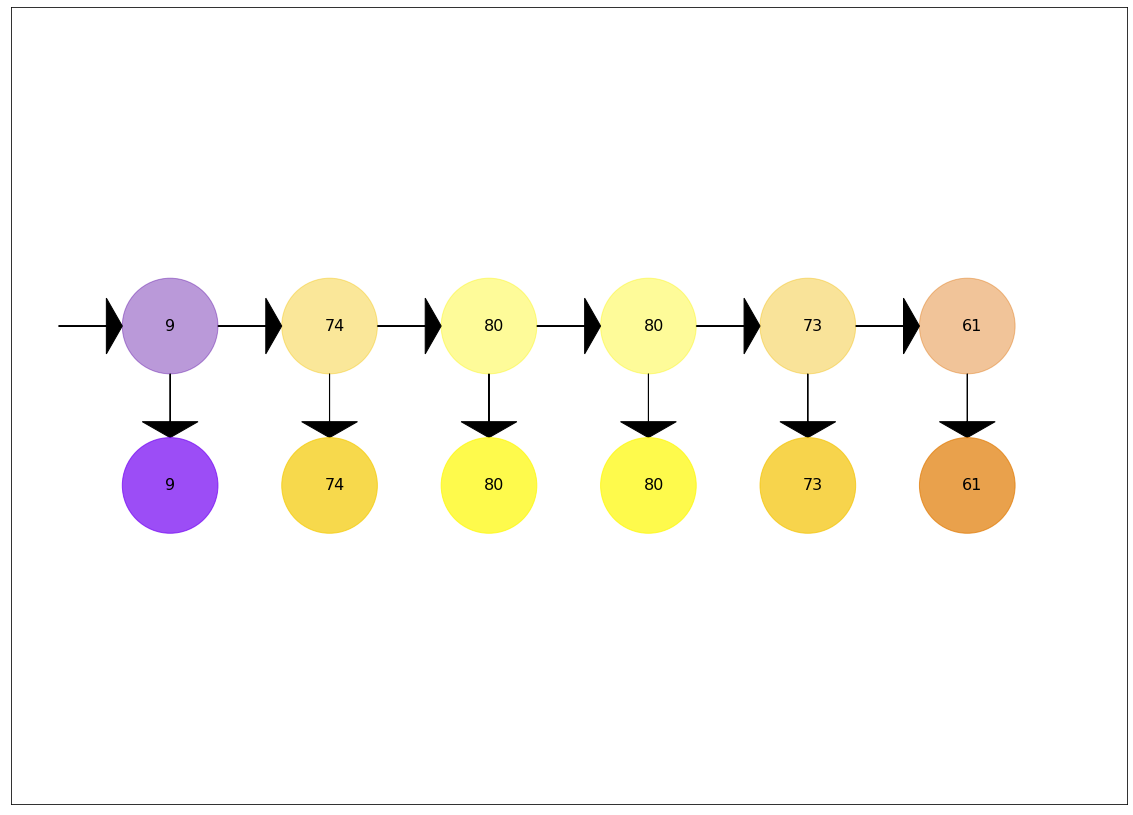

['+-++', '00+0', '0000', '0000', '00+-', '0+0-']


In [37]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = rotrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Robot overtakes right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating human crossing robot path from left HMM

In [38]:
pcl_seqs = pcl_study_seqs
pcl_seqs

[['---+'],
 ['---+', '----'],
 ['---+', '----', '+---'],
 ['---+'],
 ['---+', '---0'],
 ['---+', '---0', '----'],
 ['---+', '---0', '----', '+---'],
 ['---+', '---0', '----', '+---', '----'],
 ['---+'],
 ['---+', '----'],
 ['---+', '----', '+---'],
 ['---+'],
 ['---+', '----'],
 ['---+', '----', '+---'],
 ['---+'],
 ['---+', '---0'],
 ['---+', '---0', '0---'],
 ['---+', '---0', '0---', '+---'],
 ['---+'],
 ['---+', '--++'],
 ['---+', '--++', '+---'],
 ['---+'],
 ['---+', '----'],
 ['---+', '----', '0---'],
 ['---+', '----', '0---', '+---'],
 ['---+'],
 ['---+', '---0'],
 ['---+', '---0', '----'],
 ['---+', '---0', '----', '+---'],
 ['---+'],
 ['---+', '----'],
 ['---+', '----', '-+++'],
 ['---+'],
 ['---+', '---0'],
 ['---+', '---0', '--+-'],
 ['---+', '---0', '--+-', '++++'],
 ['+---'],
 ['--++'],
 ['--++', '---+'],
 ['--++', '---+', '---0'],
 ['--++', '---+', '---0', '----'],
 ['--++', '---+', '---0', '----', '+---'],
 ['---+'],
 ['---+', '---0'],
 ['---+', '---0', '+---'],
 ['---+']

In [39]:
pcl_seqs = [list(map(QTC_C_to_num, seq)) for seq in pcl_seqs]
print(pcl_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pcl_seqs]

[[39], [39, 40], [39, 40, 13], [39], [39, 41], [39, 41, 40], [39, 41, 40, 13], [39, 41, 40, 13, 40], [39], [39, 40], [39, 40, 13], [39], [39, 40], [39, 40, 13], [39], [39, 41], [39, 41, 67], [39, 41, 67, 13], [39], [39, 36], [39, 36, 13], [39], [39, 40], [39, 40, 67], [39, 40, 67, 13], [39], [39, 41], [39, 41, 40], [39, 41, 40, 13], [39], [39, 40], [39, 40, 27], [39], [39, 41], [39, 41, 37], [39, 41, 37, 0], [13], [36], [36, 39], [36, 39, 41], [36, 39, 41, 40], [36, 39, 41, 40, 13], [39], [39, 41], [39, 41, 13], [39], [39, 41], [39, 41, 40], [39, 41, 40, 13], [39], [39, 41], [39, 41, 40], [39, 41, 40, 67], [39, 41, 40, 67, 40], [39, 41, 40, 67, 40, 13], [39], [39, 41], [39, 41, 40], [39, 41, 40, 13], [36], [36, 39], [36, 39, 41], [39], [39, 41], [39, 41, 40], [39, 41, 40, 13], [39], [39, 41], [39, 41, 40], [39, 41, 40, 13], [39], [39, 40], [39, 40, 13]]


[['---+'],
 ['---+', '----'],
 ['---+', '----', '+---'],
 ['---+'],
 ['---+', '---0'],
 ['---+', '---0', '----'],
 ['---+', '---0', '----', '+---'],
 ['---+', '---0', '----', '+---', '----'],
 ['---+'],
 ['---+', '----'],
 ['---+', '----', '+---'],
 ['---+'],
 ['---+', '----'],
 ['---+', '----', '+---'],
 ['---+'],
 ['---+', '---0'],
 ['---+', '---0', '0---'],
 ['---+', '---0', '0---', '+---'],
 ['---+'],
 ['---+', '--++'],
 ['---+', '--++', '+---'],
 ['---+'],
 ['---+', '----'],
 ['---+', '----', '0---'],
 ['---+', '----', '0---', '+---'],
 ['---+'],
 ['---+', '---0'],
 ['---+', '---0', '----'],
 ['---+', '---0', '----', '+---'],
 ['---+'],
 ['---+', '----'],
 ['---+', '----', '-+++'],
 ['---+'],
 ['---+', '---0'],
 ['---+', '---0', '--+-'],
 ['---+', '---0', '--+-', '++++'],
 ['+---'],
 ['--++'],
 ['--++', '---+'],
 ['--++', '---+', '---0'],
 ['--++', '---+', '---0', '----'],
 ['--++', '---+', '---0', '----', '+---'],
 ['---+'],
 ['---+', '---0'],
 ['---+', '---0', '+---'],
 ['---+']

In [40]:
# Create transition matrix from handwritten examples of path-crossing QTC_C sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pcl_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
0
1
0
0
1
0
1
2
0
1
2
3
0
0
1
0
0
1
0
0
1
0
1
2
0
0
1
0
0
1
0
1
2
0
0
1
0
1
2
0
0
1
0
0
1
0
1
2
0
0
1
0
1
2
0
1
2
3
0
0
1
0
0
1
0
1
2
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
0
1
0
1
2
0
0
1
0
0
1
0
1
2
0
0
1
0
1
2
0
0
1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [41]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
for seq in pcl_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
pclHMM = hmms.DtHMM(A, B, Pi)

# Check otHMM params
A, B, Pi = pclHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.36837827e-02 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.08521881e-01 1.35482997e-04 1.35482997e-04 8.67226663e-01
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35482997e-04 1.35482997e-04 1.35482997e-04
 1.35482997e-04 1.35

In [42]:
A.min()

0.0001930129318664352

In [43]:
# draw_transition_matrix(A, "QTC_C_Path_Crossing_Lab_Egs_Transitions", 0.0124)

Path-crossing left HMM:


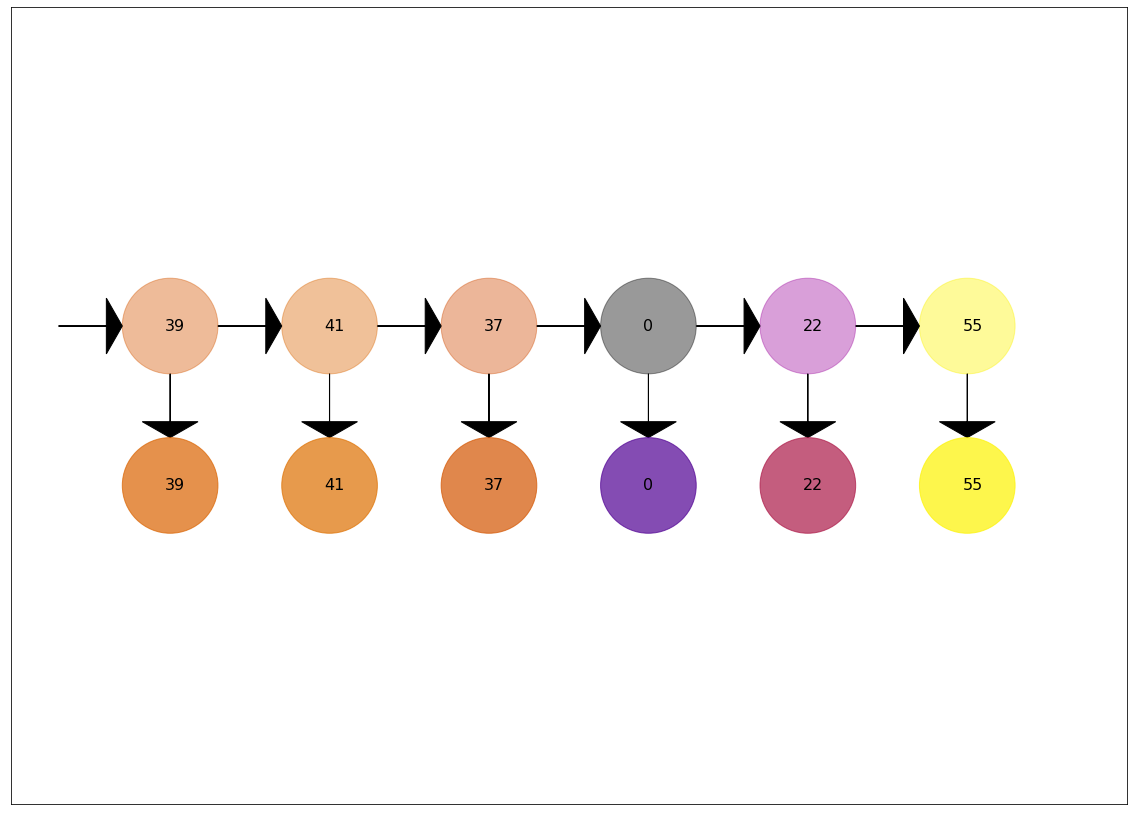

['---+', '---0', '--+-', '++++', '+0--', '0++-']


In [44]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pclHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Path-crossing left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating human crossing robot path from right HMM

In [45]:
pcr_seqs = pcr_study_seqs

In [46]:
pcr_seqs = [list(map(QTC_C_to_num, seq)) for seq in pcr_seqs]
print(pcr_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pcr_seqs]

[[37], [37, 10], [37], [37, 64], [37], [37, 10], [37, 10, 9], [37], [37, 36], [37], [37, 11], [37], [37, 10], [37, 10, 9], [37], [37], [37, 0], [37], [37, 10], [37], [37], [37, 11], [37, 11, 9], [37], [37, 64], [37, 64, 10], [37, 64, 10, 11], [37, 64, 10, 11, 9], [37], [37, 10], [37, 10, 11], [37], [37, 10], [37, 10, 11], [37], [37, 13], [37, 13, 37], [37, 13, 37, 10], [37, 13, 37, 10, 11], [37], [37, 11], [37], [37, 10], [10], [10, 11], [10, 11, 9], [10], [10, 9], [37], [37, 11]]


[['--+-'],
 ['--+-', '+-+-'],
 ['--+-'],
 ['--+-', '0-+-'],
 ['--+-'],
 ['--+-', '+-+-'],
 ['--+-', '+-+-', '+-++'],
 ['--+-'],
 ['--+-', '--++'],
 ['--+-'],
 ['--+-', '+-+0'],
 ['--+-'],
 ['--+-', '+-+-'],
 ['--+-', '+-+-', '+-++'],
 ['--+-'],
 ['--+-'],
 ['--+-', '++++'],
 ['--+-'],
 ['--+-', '+-+-'],
 ['--+-'],
 ['--+-'],
 ['--+-', '+-+0'],
 ['--+-', '+-+0', '+-++'],
 ['--+-'],
 ['--+-', '0-+-'],
 ['--+-', '0-+-', '+-+-'],
 ['--+-', '0-+-', '+-+-', '+-+0'],
 ['--+-', '0-+-', '+-+-', '+-+0', '+-++'],
 ['--+-'],
 ['--+-', '+-+-'],
 ['--+-', '+-+-', '+-+0'],
 ['--+-'],
 ['--+-', '+-+-'],
 ['--+-', '+-+-', '+-+0'],
 ['--+-'],
 ['--+-', '+---'],
 ['--+-', '+---', '--+-'],
 ['--+-', '+---', '--+-', '+-+-'],
 ['--+-', '+---', '--+-', '+-+-', '+-+0'],
 ['--+-'],
 ['--+-', '+-+0'],
 ['--+-'],
 ['--+-', '+-+-'],
 ['+-+-'],
 ['+-+-', '+-+0'],
 ['+-+-', '+-+0', '+-++'],
 ['+-+-'],
 ['+-+-', '+-++'],
 ['--+-'],
 ['--+-', '+-+0']]

In [47]:
# Create transition matrix from handwritten examples of path-crossing QTC_C sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pcr_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
0
0
0
1
0
0
0
0
1
0
0
0
0
1
0
0
1
0
1
2
0
1
2
3
0
0
1
0
0
1
0
0
1
0
1
2
0
1
2
3
0
0
0
0
1
0
0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [48]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
for seq in pcr_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
pcrHMM = hmms.DtHMM(A, B, Pi)

# Check otHMM params
A, B, Pi = pcrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 9.86026373e-02 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 8.85849242e-01 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96811651e-04 1.96811651e-04 1.96811651e-04
 1.96811651e-04 1.96

In [49]:
A.min()

0.0003354579000335457

In [50]:
# draw_transition_matrix(A, "QTC_C_Path_Crossing_Lab_Egs_Transitions", 0.0124)

Path-crossing right HMM:


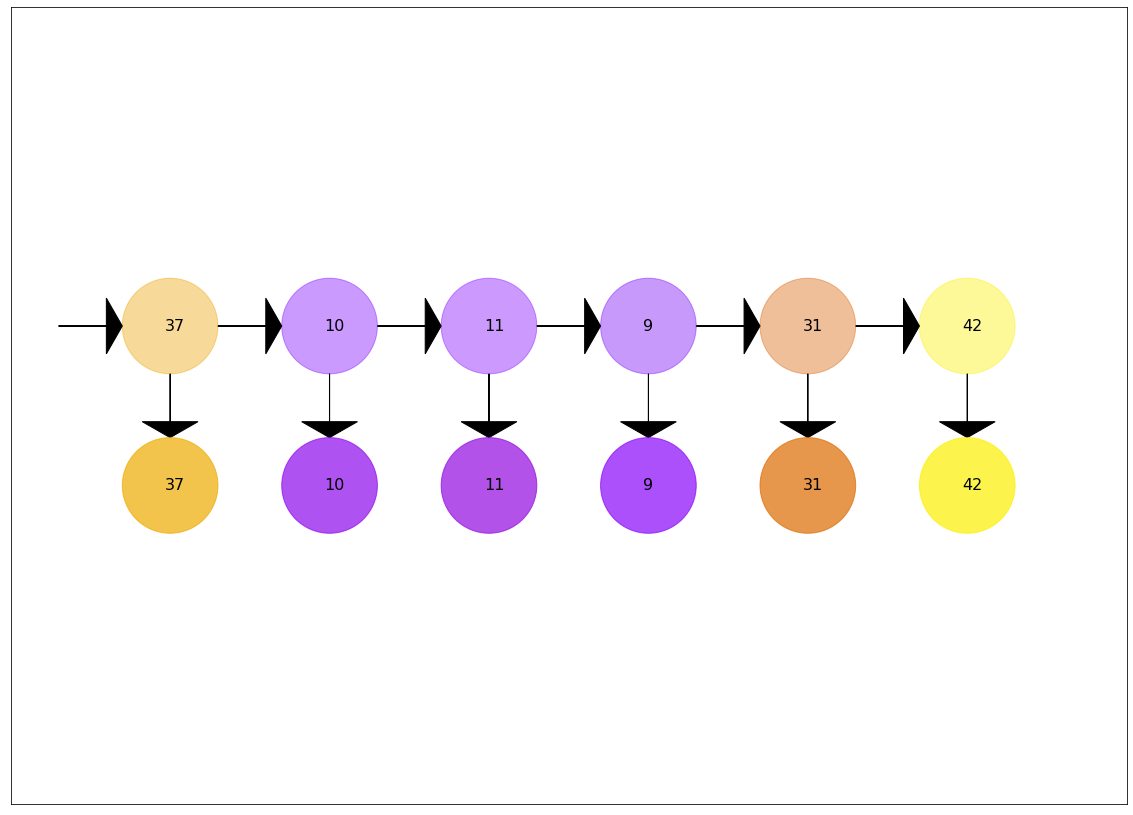

['--+-', '+-+-', '+-+0', '+-++', '-+--', '--0+']


In [51]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pcrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Path-crossing right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

In [52]:
def classify_QTC_seqs(e_seqs):
    ll_pb_l = pblHMM.data_estimate(e_seqs)
    # print(ll_pb_l)
    prob_pb_l = np.exp(ll_pb_l)

    # print("The probability of the dataset being generated by the pass-by left model is:", \
    #       prob_pb_l, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs)
    # print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

    # print("The probability of the dataset being generated by the pass-by right model is:", \
    #       prob_pb_r, ".")

    # print("The probability of the dataset being generated by the rejection model is:", \
    #       prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs)
    # print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

    # print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #       prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs)
    # print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

    # print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #       prob_rotr, ".")

    ll_pcl = pclHMM.data_estimate(e_seqs)
    # print(ll_pcl)
    prob_pcl = np.exp(ll_pcl)
    
    ll_pcr = pcrHMM.data_estimate(e_seqs)
    # print(ll_pcr)
    prob_pcr = np.exp(ll_pcr)

    lls = [ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pcl, ll_pcr]
    class_id = np.argmax(lls)
    KL = entropy(lls, [1/len(lls) for ll in lls])
    if KL > rejection_KL_thresh:
        pred = classes[class_id]
    else:
        pred = "rejection"
        class_id = len(classes)
    print("Classified as", pred)
    print("KL divergence of likelihoods from uniform distribution:", KL)
    
    return class_id

## Classifying HRI situation of unmodelled QTC<sub>C</sub> sequences

In [53]:
u_seqs = u_study_seqs

In [54]:
u_seqs = [list(map(QTC_C_to_num, seq)) for seq in u_seqs]
print(u_seqs)
[list(map(num_to_QTC_C, seq)) for seq in u_seqs]

[[67], [67, 43], [67, 43, 37], [67, 43, 37, 64], [67, 43, 37, 64, 13], [67, 43, 37, 64, 13, 64], [67, 43, 37, 64, 13, 64, 10], [67, 43, 37, 64, 13, 64, 10, 67], [67, 43, 37, 64, 13, 64, 10, 67, 40], [67, 43, 37, 64, 13, 64, 10, 67, 40, 76], [67, 43, 37, 64, 13, 64, 10, 67, 40, 76, 80], [67, 43, 37, 64, 13, 64, 10, 67, 40, 76, 80, 74], [67, 43, 37, 64, 13, 64, 10, 67, 40, 76, 80, 74, 80], [40], [40, 43], [40, 43, 64], [40, 43, 64, 37], [40, 43, 64, 37, 64], [40, 43, 64, 37, 64, 10], [40, 43, 64, 37, 64, 10, 40], [40, 43, 64, 37, 64, 10, 40, 67], [40, 43, 64, 37, 64, 10, 40, 67, 74], [40, 43, 64, 37, 64, 10, 40, 67, 74, 80], [39], [39, 63], [39, 63, 9], [39, 63, 9, 42], [39, 63, 9, 42, 12], [39, 63, 9, 42, 12, 69], [39, 63, 9, 42, 12, 69, 39], [39, 63, 9, 42, 12, 69, 39, 15], [39, 63, 9, 42, 12, 69, 39, 15, 36], [39, 63, 9, 42, 12, 69, 39, 15, 36, 12], [39, 63, 9, 42, 12, 69, 39, 15, 36, 12, 69], [39, 63, 9, 42, 12, 69, 39, 15, 36, 12, 69, 36], [39, 63, 9, 42, 12, 69, 39, 15, 36, 12, 69,

[['0---'],
 ['0---', '--0-'],
 ['0---', '--0-', '--+-'],
 ['0---', '--0-', '--+-', '0-+-'],
 ['0---', '--0-', '--+-', '0-+-', '+---'],
 ['0---', '--0-', '--+-', '0-+-', '+---', '0-+-'],
 ['0---', '--0-', '--+-', '0-+-', '+---', '0-+-', '+-+-'],
 ['0---', '--0-', '--+-', '0-+-', '+---', '0-+-', '+-+-', '0---'],
 ['0---', '--0-', '--+-', '0-+-', '+---', '0-+-', '+-+-', '0---', '----'],
 ['0---',
  '--0-',
  '--+-',
  '0-+-',
  '+---',
  '0-+-',
  '+-+-',
  '0---',
  '----',
  '00--'],
 ['0---',
  '--0-',
  '--+-',
  '0-+-',
  '+---',
  '0-+-',
  '+-+-',
  '0---',
  '----',
  '00--',
  '0000'],
 ['0---',
  '--0-',
  '--+-',
  '0-+-',
  '+---',
  '0-+-',
  '+-+-',
  '0---',
  '----',
  '00--',
  '0000',
  '00+0'],
 ['0---',
  '--0-',
  '--+-',
  '0-+-',
  '+---',
  '0-+-',
  '+-+-',
  '0---',
  '----',
  '00--',
  '0000',
  '00+0',
  '0000'],
 ['----'],
 ['----', '--0-'],
 ['----', '--0-', '0-+-'],
 ['----', '--0-', '0-+-', '--+-'],
 ['----', '--0-', '0-+-', '--+-', '0-+-'],
 ['----', '--0

In [55]:
u_seqs = [np.array(seq) for seq in u_seqs]

In [56]:
# Generate dataset of both hidden states and emissions sequences from uniform HMM
# symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_seq] for u_seq in u_seqs]
e_seqs = np.array(u_seqs)

classify_QTC_seqs(e_seqs)

Classified as rejection
KL divergence of likelihoods from uniform distribution: 0.0003123757068409635


6

## Classifying HRI situation of example pass-by left QTC<sub>C</sub> sequences

In [202]:
pass_by_l_seqs = [np.array(seq) for seq in pass_by_l_seqs]

In [203]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_l_seqs)

classify_QTC_seqs(e_seqs)

Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.09107294810953219


0

## Classifying HRI situation of example pass-by right QTC<sub>C</sub> sequences

In [204]:
pass_by_r_seqs = [np.array(seq) for seq in pass_by_r_seqs]

In [205]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_r_seqs)

classify_QTC_seqs(e_seqs)

Classified as PBR
KL divergence of likelihoods from uniform distribution: 0.10194829889998816


1

## Classifying HRI situation of example robot overtaking left QTC<sub>C</sub> sequences

In [206]:
rotl_seqs = [np.array(seq) for seq in rotl_seqs]

In [207]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(rotl_seqs)

classify_QTC_seqs(e_seqs)

Classified as ROTL
KL divergence of likelihoods from uniform distribution: 0.07422450540964307


2

## Classifying HRI situation of example robot overtaking right QTC<sub>C</sub> sequences

In [208]:
rotr_seqs = [np.array(seq) for seq in rotr_seqs]

In [209]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(rotr_seqs)

classify_QTC_seqs(e_seqs)

Classified as ROTR
KL divergence of likelihoods from uniform distribution: 0.09214182399339305


3

## Classifying HRI situation of example path-crossing left QTC<sub>C</sub> sequences

In [210]:
pcl_seqs = [np.array(seq) for seq in pcl_seqs]

In [211]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pcl_seqs)

classify_QTC_seqs(e_seqs)

Classified as PCL
KL divergence of likelihoods from uniform distribution: 0.1152277474568479


4

## Classifying HRI situation of example path-crossing right QTC<sub>C</sub> sequences

In [212]:
pcr_seqs = [np.array(seq) for seq in pcr_seqs]

In [213]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pcr_seqs)

classify_QTC_seqs(e_seqs)

Classified as PCR
KL divergence of likelihoods from uniform distribution: 0.1257367280242225


5

<!-- ## Classifying HRI situation of individual lab QTC<sub>C</sub> sequences -->

In [214]:
# Get hidden states and emissions sequences from observed sequences
# sequence_no = 5

KLs = []
for sequence_no in range(len(u_study_seqs)):
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_study_seqs[i]] for i in range(len(u_study_seqs))]
    e_seqs = np.array([symbol_seqs[sequence_no]])
    
    ll_pb_l = pblHMM.data_estimate(e_seqs)
    # print(ll_pb_l)
    prob_pb_l = np.exp(ll_pb_l)

    # print("The probability of the dataset being generated by the pass-by left model is:", \
    #       prob_pb_l, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs)
    # print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

    # print("The probability of the dataset being generated by the pass-by right model is:", \
    #       prob_pb_r, ".")

    # print("The probability of the dataset being generated by the rejection model is:", \
    #       prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs)
    # print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

    # print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #       prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs)
    # print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

    # print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #       prob_rotr, ".")

    ll_pcl = pclHMM.data_estimate(e_seqs)
    # print(ll_pc)
    prob_pcl = np.exp(ll_pcl)
    
    ll_pcr = pcrHMM.data_estimate(e_seqs)
    # print(ll_pc)
    prob_pcr = np.exp(ll_pcr)

    # print("The probability of the dataset being generated by the path-crossing model is:", \
    #       prob_pc, ".")

    # lls = [ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform]
    # classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]

    lls = [ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pcl, ll_pcr]
    class_id = np.argmax(lls)
    KL = entropy(lls, [1/len(lls) for ll in lls])
    KLs.append(KL)
    if KL > rejection_KL_thresh:
        pred = classes[class_id]
    else:
        pred = "rejection"
        class_id = len(classes)
    print("Classified as", pred)
#     print("KL divergence of likelihoods from uniform distribution:", KL)

Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as PBL
Classified as PBL
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection


In [215]:
print("KLs:\n")
print("Min:", np.min(KLs))
print("Median", np.median(KLs))
print("Mean", np.mean(KLs))
print("Max:", np.max(KLs))

KLs:

Min: 2.7533075888074954e-05
Median 0.0015264399607778558
Mean 0.00844621804847745
Max: 0.13142181562332578


## K-fold CV of Classifying HRSI situation of all expert QTC<sub>C</sub> sequences

In [216]:
rotl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(rotl_study_seqs):
    rotl_splits.append([train_index, test_index])
    
rotl_splits

[[array([ 1,  3,  4,  5,  6,  7,  8, 10, 11, 15, 18, 19, 20, 21, 22, 23, 25,
         26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40]),
  array([ 0,  2,  9, 12, 13, 14, 16, 17, 24, 29, 37, 41, 42, 43, 44])],
 [array([ 0,  2,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24,
         26, 28, 29, 31, 34, 36, 37, 39, 40, 41, 42, 43, 44]),
  array([ 1,  3,  4,  5,  6, 10, 19, 23, 25, 27, 30, 32, 33, 35, 38])],
 [array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 12, 13, 14, 16, 17, 19, 23, 24,
         25, 27, 29, 30, 32, 33, 35, 37, 38, 41, 42, 43, 44]),
  array([ 7,  8, 11, 15, 18, 20, 21, 22, 26, 28, 31, 34, 36, 39, 40])]]

In [217]:
rotr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(rotr_study_seqs):
    rotr_splits.append([train_index, test_index])
    
rotr_splits

[[array([ 1,  2,  4,  5,  7,  8,  9, 10, 11, 13, 15, 17, 18, 19, 22]),
  array([ 0,  3,  6, 12, 14, 16, 20, 21])],
 [array([ 0,  3,  6,  8, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22]),
  array([ 1,  2,  4,  5,  7,  9, 10, 17])],
 [array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 14, 16, 17, 20, 21]),
  array([ 8, 11, 13, 15, 18, 19, 22])]]

In [218]:
pbl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pb_l_study_seqs):
    pbl_splits.append([train_index, test_index])
    
pbl_splits

[[array([ 2,  4,  5,  7,  8, 10, 11, 12, 13, 15, 17, 18, 21, 22, 23, 25, 26,
         27, 28]), array([ 0,  1,  3,  6,  9, 14, 16, 19, 20, 24])],
 [array([ 0,  1,  3,  6,  8,  9, 11, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24,
         25, 28]), array([ 2,  4,  5,  7, 10, 12, 17, 21, 26, 27])],
 [array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 14, 16, 17, 19, 20, 21,
         24, 26, 27]), array([ 8, 11, 13, 15, 18, 22, 23, 25, 28])]]

In [219]:
pbr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pb_r_study_seqs):
    pbr_splits.append([train_index, test_index])
    
pbr_splits

[[array([ 1,  2,  4,  5,  7,  8, 10, 11, 13, 14, 15, 18, 19, 21, 22, 23, 25]),
  array([ 0,  3,  6,  9, 12, 16, 17, 20, 24])],
 [array([ 0,  3,  6,  8,  9, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 24, 25]),
  array([ 1,  2,  4,  5,  7, 10, 14, 19, 23])],
 [array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 14, 16, 17, 19, 20, 23,
         24]), array([ 8, 11, 13, 15, 18, 21, 22, 25])]]

In [220]:
pcl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pcl_study_seqs):
    pcl_splits.append([train_index, test_index])
    
pcl_splits

[[array([ 2,  3,  4,  5,  6,  7,  8, 10, 11, 15, 17, 18, 19, 20, 21, 22, 23,
         26, 29, 31, 32, 33, 34, 35]),
  array([ 0,  1,  9, 12, 13, 14, 16, 24, 25, 27, 28, 30])],
 [array([ 0,  1,  2,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 24,
         25, 27, 28, 30, 31, 34, 35]),
  array([ 3,  4,  5,  6, 10, 19, 20, 23, 26, 29, 32, 33])],
 [array([ 0,  1,  3,  4,  5,  6,  9, 10, 12, 13, 14, 16, 19, 20, 23, 24, 25,
         26, 27, 28, 29, 30, 32, 33]),
  array([ 2,  7,  8, 11, 15, 17, 18, 21, 22, 31, 34, 35])]]

In [221]:
pcr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pcr_study_seqs):
    pcr_splits.append([train_index, test_index])
    
pcr_splits

[[array([ 1,  2,  6,  7,  8, 10, 11, 13, 14, 15, 16, 17, 19]),
  array([ 0,  3,  4,  5,  9, 12, 18])],
 [array([ 0,  3,  4,  5,  6,  8,  9, 11, 12, 13, 15, 18, 19]),
  array([ 1,  2,  7, 10, 14, 16, 17])],
 [array([ 0,  1,  2,  3,  4,  5,  7,  9, 10, 12, 14, 16, 17, 18]),
  array([ 6,  8, 11, 13, 15, 19])]]

In [222]:
overall_accs = []
rotl_accs = []
rotr_accs = []
pbl_accs = []
pbr_accs = []
pcl_accs = []
pcr_accs = []
u_accs = []
y_true = []
y_pred = []

for k in range(K):    
    rotl_study_seqs_train = np.array(rotl_study_seqs)[rotl_splits[k][0]]
    rotl_study_seqs_val = np.array(rotl_study_seqs)[rotl_splits[k][1]]
    
    rotr_study_seqs_train = np.array(rotr_study_seqs)[rotr_splits[k][0]]
    rotr_study_seqs_val = np.array(rotr_study_seqs)[rotr_splits[k][1]]
    
    pb_l_study_seqs_train = np.array(pb_l_study_seqs)[pbl_splits[k][0]]
    pb_l_study_seqs_val = np.array(pb_l_study_seqs)[pbl_splits[k][1]]
    
    pb_r_study_seqs_train = np.array(pb_r_study_seqs)[pbr_splits[k][0]]
    pb_r_study_seqs_val = np.array(pb_r_study_seqs)[pbr_splits[k][1]]
    
    pcl_study_seqs_train = np.array(pcl_study_seqs)[pcl_splits[k][0]]
    pcl_study_seqs_val = np.array(pcl_study_seqs)[pcl_splits[k][1]]
    
    pcr_study_seqs_train = np.array(pcr_study_seqs)[pcr_splits[k][0]]
    pcr_study_seqs_val = np.array(pcr_study_seqs)[pcr_splits[k][1]]

    
    u_study_seqs_val = u_study_seqs
    
        
    ## Re-build models from training data
    ## Creating pass-by left HMM

    pass_by_l_seqs = pb_l_study_seqs_train

    pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]
#     print(pass_by_l_seqs)
#     [list(map(num_to_QTC_C, seq)) for seq in pass_by_l_seqs]

    # Create transition matrix from handwritten examples of pass-by QTC-B sequences
    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pass_by_l_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())

    # Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pass_by_l_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

    # print(Pi)
    # print(Pi.sum())

    # Create HMM using the pass-by e.g. parameters
    pblHMM = hmms.DtHMM(A, B, Pi)

    # Check pblHMM params
    A, B, Pi = pblHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

#     pass_by_l_seqs = tuple(pass_by_l_seqs)
    pass_by_l_seqs = [np.asarray(seq) for seq in pass_by_l_seqs]
    pass_by_l_seqs = np.asarray(pass_by_l_seqs)
#     print(pass_by_l_seqs)
#     pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]

    ## Creating pass-by right HMM

    pass_by_r_seqs = pb_r_study_seqs_train

    pass_by_r_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_r_seqs]
#     print(pass_by_r_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in pass_by_r_seqs]

    # Create transition matrix from handwritten examples of pass-by QTC-B sequences
    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pass_by_r_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())

    # Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pass_by_r_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

    # print(Pi)
    # print(Pi.sum())

    # Create HMM using the pass-by e.g. parameters
    pbrHMM = hmms.DtHMM(A, B, Pi)

    # Check pbrHMM params
    A, B, Pi = pbrHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating robot overtakes left HMM

    rotl_seqs = rotl_study_seqs_train

    rotl_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotl_seqs]
#     print(rotl_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in rotl_seqs]

    # Create transition matrix from handwritten examples of overtake QTC-B sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in rotl_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in rotl_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the overtake e.g. parameters
    rotlHMM = hmms.DtHMM(A, B, Pi)

    # Check rotlHMM params
    A, B, Pi = rotlHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating robot overtakes right HMM

    rotr_seqs = rotr_study_seqs_train

    rotr_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotr_seqs]
#     print(rotr_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in rotr_seqs]

    # Create transition matrix from handwritten examples of overtake QTC-B sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in rotr_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in rotr_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the overtake e.g. parameters
    rotrHMM = hmms.DtHMM(A, B, Pi)

    # Check rotrHMM params
    A, B, Pi = rotrHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating path-crossing left HMM

    pcl_seqs = pcl_study_seqs_train

    pcl_seqs = [list(map(QTC_C_to_num, seq)) for seq in pcl_seqs]
#     print(pc_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in pcl_seqs]

    # Create transition matrix from handwritten examples of path-crossing QTC_C sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pcl_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pcl_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the path-crossing e.g. parameters
    pclHMM = hmms.DtHMM(A, B, Pi)

    # Check pcHMM params
    A, B, Pi = pclHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())


    ## Creating path-crossing right HMM

    pcr_seqs = pcr_study_seqs_train

    pcr_seqs = [list(map(QTC_C_to_num, seq)) for seq in pcr_seqs]
#     print(pc_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in pcr_seqs]

    # Create transition matrix from handwritten examples of path-crossing QTC_C sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pcr_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pcr_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the path-crossing e.g. parameters
    pcrHMM = hmms.DtHMM(A, B, Pi)

    # Check pcHMM params
    A, B, Pi = pcrHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())
            
    
    # Get correct count and accuracy of pass-by left classifications
    pb_l_correct = 0
    for pb_l_seq in pb_l_study_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_l_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = 0
        y_true.append(correct_class_id)
        y_pred.append(class_id)
        
        if class_id == correct_class_id:
            pb_l_correct += 1
            
        pb_l_acc = pb_l_correct/len(pb_l_study_seqs_val)*100
#     print("Pass-by left classifications are " + str(pb_l_acc) + "% accurate" )

    # Get correct count and accuracy of pass-by right classifications
    pb_r_correct = 0
    for pb_r_seq in pb_r_study_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_r_seq]]
        e_seqs = np.array(symbol_seqs)
        
        class_id = classify_QTC_seqs(e_seqs)
        
        correct_class_id = 1
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            pb_r_correct += 1
            
        pb_r_acc = (pb_r_correct/len(pb_r_study_seqs_val))*100
#     print("Pass-by right classifications are " + str(pb_r_acc) + "% accurate" )

    # Get correct count and accuracy of robot overtaking left classifications
    rotl_correct = 0
    for rotl_seq in rotl_study_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in rotl_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = 2
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            rotl_correct += 1
            
        rotl_acc = (rotl_correct/len(rotl_study_seqs_val))*100
#     print("Robot overtaking left classifications are " + str(rotl_acc) + "% accurate" )

    # Get correct count and accuracy of robot overtaking right classifications
    rotr_correct = 0
    for rotr_seq in rotr_study_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in rotr_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = 3
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            rotr_correct += 1
            
        rotr_acc = (rotr_correct/len(rotr_study_seqs_val))*100
#     print("Robot overtaking right classifications are " + str(rotr_acc) + "% accurate" )

    # Get correct count and accuracy of path-crossing left classifications
    pcls_correct = 0
    for pcl_seq in pcl_study_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pcl_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = 4
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            pcls_correct += 1
            
        pcl_acc = (pcls_correct/len(pcl_study_seqs_val))*100
#     print("Path-crossing left classifications are " + str(pcl_acc) + "% accurate" )


# Get correct count and accuracy of path-crossing right classifications
    pcrs_correct = 0
    for pcr_seq in pcr_study_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pcr_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = 5
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            pcrs_correct += 1
            
        pcr_acc = (pcrs_correct/len(pcr_study_seqs_val))*100
#     print("Path-crossing classifications are " + str(pc_acc) + "% accurate" )

    # Get correct count and accuracy of rejections
    us_correct = 0
    for u_seq in u_study_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = len(classes)
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            us_correct += 1

    # Rejections recall
    rTPs = us_correct
    rFNs = len(u_study_seqs_val) - us_correct
    # rFPs = 0 # As accuracy in all other classes is 100%
    recall = rTPs / (rTPs + rFNs)
    # precision = rTPs / (rTPs + rFPs)
    
    u_acc = us_correct/len(u_study_seqs_val)*100

#     print("Rejections FN rate: " + str((rFNs/len(u_study_seqs_val)*100)) + "%")
#     print("Rejections accuracy: " + str(u_acc) + "%" )
#     print("Rejection recall:", str(recall * 100) + "%")
    # print("Rejection precision:", str(precision * 100) + "%")

    total = len(pb_l_study_seqs_val) + len(pb_r_study_seqs_val) + len(rotl_study_seqs_val) + len(rotl_study_seqs_val) + len(pcl_study_seqs_val) + len(pcr_study_seqs_val)
    total_correct = pb_l_correct + pb_r_correct + rotr_correct + rotl_correct + pcls_correct + pcrs_correct

    overall_acc = (total_correct/total)*100
    print("k", k+1, "/", K)
    print("\nOverall accuracy (excluding rejections): " + str(overall_acc) + "%")
    print("Robot overtaking left TPR: " + str(np.mean(rotl_acc)) + "%")
    print("Robot overtaking right TPR: " + str(np.mean(rotr_acc)) + "%")
    print("Pass-by left TPR: " + str(np.mean(pb_l_acc)) + "%")
    print("Pass-by right TPR: " + str(np.mean(pb_r_acc)) + "%")
    print("Path-crossing left TPR: " + str(np.mean(pcl_acc)) + "%")
    print("Path-crossing right TPR: " + str(np.mean(pcr_acc)) + "%")
    print("Rejection TPR: " + str(np.mean(u_acc)) + "%\n")
    
    overall_accs.append(overall_acc)
    rotl_accs.append(rotl_acc)
    rotr_accs.append(rotr_acc)
    pbl_accs.append(pb_l_acc)
    pbr_accs.append(pb_r_acc)
    pcl_accs.append(pcl_acc)
    pcr_accs.append(pcr_acc)
    u_accs.append(u_acc)
    
    if k == 2:
        pblHMM.save_params("pblHMM_k_3_hf")
        pbrHMM.save_params("pbrHMM_k_3_hf")
        rotlHMM.save_params("rotlHMM_k_3_hf")
        rotrHMM.save_params("rotrHMM_k_3_hf")
        pclHMM.save_params("pclHMM_k_3_hf")
        pcrHMM.save_params("pcrHMM_k_3_hf")

Classified as PCR
KL divergence of likelihoods from uniform distribution: 0.2767557052525161
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.07506652469965154
Classified as ROTL
KL divergence of likelihoods from uniform distribution: 0.1181261078978743
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.08914761355760026
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.03310640515996309
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.12679965454590753
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.05996518798703723
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.11935685460249709
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.11419183680372968
Classified as PCR
KL divergence of likelihoods from uniform distribution: 0.2767557052525161
Classified as PBR
KL divergence of likelihoods from uniform di

Path-crossing left TPR: 100.0%
Path-crossing right TPR: 100.0%
Rejection TPR: 91.30434782608695%

Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.0858215619848102
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.0700509570622035
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.07996899332614468
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.1263778996204303
Classified as PCR
KL divergence of likelihoods from uniform distribution: 0.2579900482128679
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.03972495788330241
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.1263778996204303
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.13048880061766002
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.03642703825534484
Classified as PBL
KL divergence of likelihoods from uniform d

Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.07078432829912835
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.1086405669453494
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.09862440026405854
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.11949011548616159
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.1179202883793174
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.09862440026405854
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.1179202883793174
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.1086405669453494
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.09862440026405854
Classified as PBR
KL divergence of likelihoods from uniform distribution: 0.07193885612285178
Classified as PBR
KL divergence of likelihoods from uniform dist

In [223]:
print("K-fold CV results:")
print("Overall accuracy: " + str(np.mean(overall_accs)) + "%")
print("Robot overtaking left TPR: " + str(np.mean(rotl_accs)) + "%")
print("Robot overtaking right TPR: " + str(np.mean(rotr_accs)) + "%")
print("Pass-by left TPR: " + str(np.mean(pbl_accs)) + "%")
print("Pass-by right TPR: " + str(np.mean(pbr_accs)) + "%")
print("Path-crossing left TPR: " + str(np.mean(pcl_accs)) + "%")
print("Path-crossing right TPR: " + str(np.mean(pcr_accs)) + "%")
print("Rejection TPR: " + str(np.mean(u_accs)) + "%")

K-fold CV results:
Overall accuracy: 86.58371040723982%
Robot overtaking left TPR: 97.77777777777777%
Robot overtaking right TPR: 100.0%
Pass-by left TPR: 86.66666666666667%
Pass-by right TPR: 100.0%
Path-crossing left TPR: 100.0%
Path-crossing right TPR: 100.0%
Rejection TPR: 91.30434782608695%


In [224]:
len(classes)

6

In [225]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[25,  0,  1,  0,  0,  3,  0],
       [ 0, 26,  0,  0,  0,  0,  0],
       [ 1,  0, 44,  0,  0,  0,  0],
       [ 0,  0,  0, 23,  0,  0,  0],
       [ 0,  0,  0,  0, 36,  0,  0],
       [ 0,  0,  0,  0,  0, 20,  0],
       [ 6,  0,  0,  0,  0,  0, 63]])

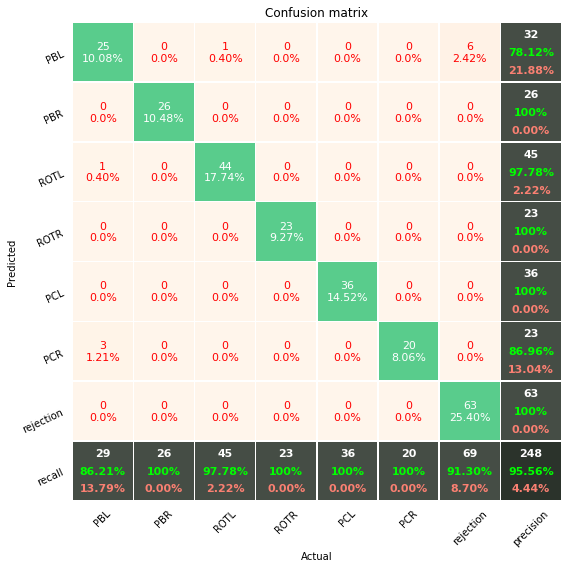

In [226]:
df_cm = pd.DataFrame(cm, range(len(classes)+1), range(len(classes)+1))
classes.append("rejection")
df_cm.columns = classes
df_cm.index = classes
df_cm

# From MATLAB plotconfusion docs (which inspired this confusion matrix plotting module):
# The column on the far right of the plot shows the percentages of all the examples predicted to belong to each
# class that are correctly and incorrectly classified. These metrics are often called the precision 
# (or positive predictive value) and false discovery rate, respectively. The row at the bottom of the plot shows
# the percentages of all the examples belonging to each class that are correctly and incorrectly classified. 
# These metrics are often called the recall (or true positive rate) and false negative rate, respectively.
# The cell in the bottom right of the plot shows the overall accuracy.
pretty_plot_confusion_matrix(df_cm, show_null_values=2)